In [1]:
# Helper functions and imports  
words = open("names.txt", 'r').read().splitlines()

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

import random
import pandas as pd
import matplotlib.pyplot as plt 
import torch
import torch.nn.functional as F 

1. Train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?

In [2]:
import torch
import torch.nn.functional as F

def build_dataset(words):
    xs, ys = [], []

    for w in words:
        chs = ['.'] + list(w) + ['.']
        for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
            ix1 = stoi[ch1]
            ix2 = stoi[ch2]
            ix3 = stoi[ch3]
            xs.append([ix1, ix2])  # When both these letters are input
            ys.append(ix3)         # The next letter should be this one

    xs = torch.tensor(xs)
    ys = torch.tensor(ys)

    print(f"The inputs are of size: {xs.shape}")
    print(f"The outputs are of size: {ys.shape}")

    return xs, ys

xs, ys = build_dataset(words)

The inputs are of size: torch.Size([196113, 2])
The outputs are of size: torch.Size([196113])


In [3]:
def train_test_trigram(xs, ys, epochs=15, eta=10, lambda_=0.01, test=False, W=None):

    if test == False:
        g = torch.Generator().manual_seed(2147483647)
        W = torch.randn((54, 27), generator=g, requires_grad=True) 
        for k in range(epochs):
            xenc = F.one_hot(xs, num_classes=27).float()
            xenc = torch.flatten(xenc, start_dim=1) # Makes it of size (# of examples, 54) so that we can do 2d matrix mult.
            logits = xenc @ W 
            counts = logits.exp()
            probs = counts / counts.sum(1, keepdims=True)
            loss = -probs[torch.arange(xs.shape[0]), ys].log().mean() + lambda_*(W**2).mean()
            print(f"Loss at step {k+1} is {loss.item()}")
            W.grad = None 
            loss.backward()
            W.data += -eta * W.grad
            
        return W
    else:
        xenc = F.one_hot(xs, num_classes=27).float()
        xenc = torch.flatten(xenc, start_dim=1)
        logits = xenc @ W 
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdims=True)
        loss = -probs[torch.arange(xs.shape[0]), ys].log().mean() + 0.01*(W**2).mean() 
        print(f"Loss is {loss.item()}")
        return loss.item() 

W = train_test_trigram(xs, ys, epochs=15, eta=10)

Loss at step 1 is 4.1959710121154785
Loss at step 2 is 3.9948556423187256
Loss at step 3 is 3.8186254501342773
Loss at step 4 is 3.665571928024292
Loss at step 5 is 3.5345680713653564
Loss at step 6 is 3.4241185188293457
Loss at step 7 is 3.3318421840667725
Loss at step 8 is 3.254584789276123
Loss at step 9 is 3.18906307220459
Loss at step 10 is 3.1325156688690186
Loss at step 11 is 3.0829358100891113
Loss at step 12 is 3.0389649868011475
Loss at step 13 is 2.9996700286865234
Loss at step 14 is 2.9643709659576416
Loss at step 15 is 2.93253231048584


> - After 15 training steps and that aggressive learning rate, we manage to beat the bigram model. But not by a lot.


2. Split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?

In [4]:
random.shuffle(words)

n = len(words)
train_end = int(0.8*n)
dev_end = int(0.9*n)

words_train, words_dev, words_test = words[:train_end], words[train_end:dev_end], words[dev_end:]

print(len(words_train) + len(words_dev) + len(words_test) == n)

True


In [5]:
xs_train, ys_train = build_dataset(words_train)

W_train = train_test_trigram(xs_train, ys_train, epochs=15, eta=50, test=False)

The inputs are of size: torch.Size([156958, 2])
The outputs are of size: torch.Size([156958])
Loss at step 1 is 4.1948771476745605
Loss at step 2 is 3.3649191856384277
Loss at step 3 is 3.0491461753845215
Loss at step 4 is 2.878418207168579
Loss at step 5 is 2.77414870262146
Loss at step 6 is 2.701547622680664
Loss at step 7 is 2.6458630561828613
Loss at step 8 is 2.6016578674316406
Loss at step 9 is 2.5655951499938965
Loss at step 10 is 2.5357425212860107
Loss at step 11 is 2.510694980621338
Loss at step 12 is 2.4894819259643555
Loss at step 13 is 2.4713244438171387
Loss at step 14 is 2.4556360244750977
Loss at step 15 is 2.441939353942871


In [6]:
xs_dev, ys_dev = build_dataset(words_dev)

dev_loss = train_test_trigram(xs_dev, ys_dev, test=True, W=W_train)

The inputs are of size: torch.Size([19641, 2])
The outputs are of size: torch.Size([19641])
Loss is 2.4406979084014893


In [7]:
xs_test, ys_test = build_dataset(words_test)

test_loss = train_test_trigram(xs_test, ys_test, test=True, W=W_train)

The inputs are of size: torch.Size([19514, 2])
The outputs are of size: torch.Size([19514])
Loss is 2.4194130897521973


> - The dev and test errors are comparable to the training errors. There is not much difference. This is a good sign. It means the model is not overfitting on the training data. 

3. Use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?

In [8]:
values = [0, 0.0001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
results = pd.DataFrame(columns=['lambda','dev loss','test loss'], index=[0])

for value in values:
    W = train_test_trigram(xs_train, ys_train, epochs=15, eta=50, lambda_=value, test=False)
    loss_dev = train_test_trigram(xs_dev, ys_dev, test=True, W=W)
    loss_test = train_test_trigram(xs_test, ys_test, test=True, W=W)
    row = pd.DataFrame({'lambda':value, 'dev loss':loss_dev, 'test loss':loss_test}, index=[0])
    results = pd.concat([results, row], ignore_index=True)

Loss at step 1 is 4.185176849365234
Loss at step 2 is 3.356907606124878
Loss at step 3 is 3.0417609214782715
Loss at step 4 is 2.871392011642456
Loss at step 5 is 2.7673845291137695
Loss at step 6 is 2.6949899196624756
Loss at step 7 is 2.639456033706665
Loss at step 8 is 2.5953567028045654
Loss at step 9 is 2.5593650341033936
Loss at step 10 is 2.5295562744140625
Loss at step 11 is 2.5045318603515625
Loss at step 12 is 2.483328342437744
Loss at step 13 is 2.4651708602905273
Loss at step 14 is 2.449474811553955
Loss at step 15 is 2.435765266418457
Loss is 2.4420270919799805
Loss is 2.420642614364624
Loss at step 1 is 4.18527364730835


C:\Users\srira\AppData\Local\Temp\ipykernel_17284\2387620845.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, row], ignore_index=True)


Loss at step 2 is 3.356987714767456
Loss at step 3 is 3.041835308074951
Loss at step 4 is 2.87146258354187
Loss at step 5 is 2.7674524784088135
Loss at step 6 is 2.695056200027466
Loss at step 7 is 2.6395206451416016
Loss at step 8 is 2.5954201221466064
Loss at step 9 is 2.559427499771118
Loss at step 10 is 2.529618978500366
Loss at step 11 is 2.504594326019287
Loss at step 12 is 2.4833908081054688
Loss at step 13 is 2.465233087539673
Loss at step 14 is 2.4495370388031006
Loss at step 15 is 2.4358279705047607
Loss is 2.4420135021209717
Loss is 2.4206299781799316
Loss at step 1 is 4.18527364730835
Loss at step 2 is 3.356987714767456
Loss at step 3 is 3.041835308074951
Loss at step 4 is 2.87146258354187
Loss at step 5 is 2.7674524784088135
Loss at step 6 is 2.695056200027466
Loss at step 7 is 2.6395206451416016
Loss at step 8 is 2.5954201221466064
Loss at step 9 is 2.559427499771118
Loss at step 10 is 2.529618978500366
Loss at step 11 is 2.504594326019287
Loss at step 12 is 2.48339080810

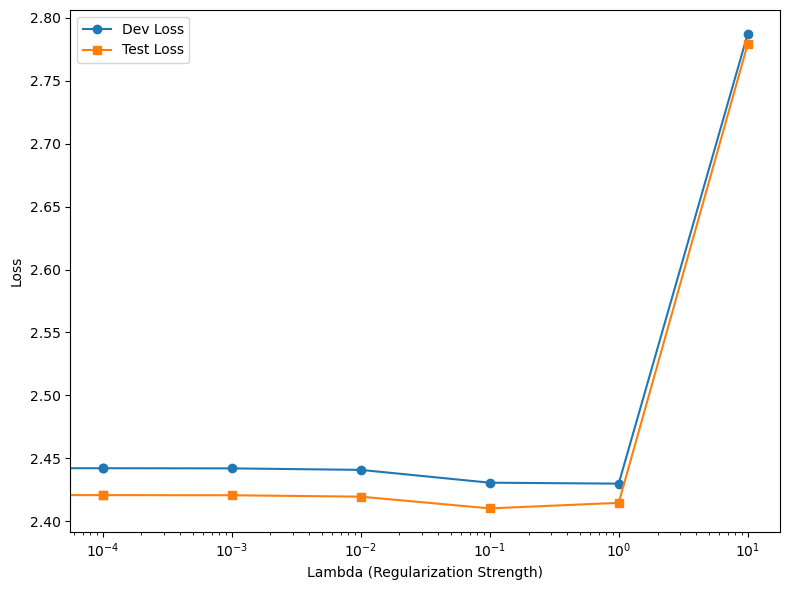

In [13]:
plt.figure(figsize=(8, 6))

plt.plot(results['lambda'], results['dev loss'], label='Dev Loss', marker='o')
plt.plot(results['lambda'], results['test loss'], label='Test Loss', marker='s')
plt.xscale('log')

# Labels and legend
plt.xlabel('Lambda (Regularization Strength)')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

> - We observe that the losses stay constant initially, then decrease and rise sharply.
> - The lowest loss (both dev and test) loss is observed @ $\lambda=0.1$

In [14]:
W_best = train_test_trigram(xs_train, ys_train, epochs=15, eta=50, lambda_=0.1, test=False)
best_test_loss = train_test_trigram(xs_test, ys_test, test=True, W=W_best)

Loss at step 1 is 4.2821807861328125
Loss at step 2 is 3.4359285831451416
Loss at step 3 is 3.1136362552642822
Loss at step 4 is 2.938922643661499
Loss at step 5 is 2.831611156463623
Loss at step 6 is 2.7565367221832275
Loss at step 7 is 2.698925256729126
Loss at step 8 is 2.653243064880371
Loss at step 9 is 2.6160454750061035
Loss at step 10 is 2.5853302478790283
Loss at step 11 is 2.5596158504486084
Loss at step 12 is 2.5378830432891846
Loss at step 13 is 2.5193099975585938
Loss at step 14 is 2.503286123275757
Loss at step 15 is 2.489316701889038
Loss is 2.410079002380371


> - The loss is not significantly smaller than before, from 2.419 --> 2.410, which is ~1% better.

4. We saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?

5. Look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?

In [41]:
def modified_train_test(xs, ys, epochs=15, eta=10, test=False, W=None):

    if test == False:
        g = torch.Generator().manual_seed(2147483647)
        W = torch.randn((54, 27), generator=g, requires_grad=True) 
        for k in range(epochs):
            ix1 = xs[:,0]
            ix2 = xs[:,1] + 27 
            logits = W[ix1] + W[ix2]
            loss = F.cross_entropy(logits, ys) + 0.01*(W**2).mean()
            print(f"Loss at step {k+1} is {loss.item()}")
            W.grad = None 
            loss.backward()
            W.data += -eta * W.grad
            
        return W
    else:
        ix1 = xs[:,0]
        ix2 = xs[:,1]+27
        logits = W[ix1] + W[ix2]
        loss = F.cross_entropy(logits,ys)
        print(f"Loss is {loss.item()}")
        return loss.item() 

In [42]:
W_ce = modified_train_test(xs_train, ys_train, epochs=15, eta=50, test=False)

Loss at step 1 is 4.194877624511719
Loss at step 2 is 3.364917278289795
Loss at step 3 is 3.0491433143615723
Loss at step 4 is 2.8784172534942627
Loss at step 5 is 2.7741482257843018
Loss at step 6 is 2.701547622680664
Loss at step 7 is 2.6458630561828613
Loss at step 8 is 2.6016576290130615
Loss at step 9 is 2.5655946731567383
Loss at step 10 is 2.53574275970459
Loss at step 11 is 2.510694980621338
Loss at step 12 is 2.4894814491271973
Loss at step 13 is 2.4713246822357178
Loss at step 14 is 2.4556360244750977
Loss at step 15 is 2.441939115524292


In [43]:
ce_test_loss = modified_train_test(xs_test, ys_test, test=True, W=W_ce)

Loss is 2.412074089050293


> - The results are very similar to the ones obtained manually. But it's preferred to use the function since it directly takes the network's output, computes the softmax probabilities and computes the cross-entropy loss.  